In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import cvxpy as cp
import matplotlib.pyplot as plt

In [2]:
class DoubleInt:  # Euler integration of curvature dynamics
    ndim = 2  # state = [kappa, kappa_dot]
    control_dim = 1  # control = kappä
    
    def __init__(self):
        self.umin = np.array([-1.0])  # min curvature rate change
        self.umax = np.array([1.0])   # max curvature rate change 
        self.dt = 0.01  # time step

    def step(self, state, control):
        print("Control dimensions inside step:", np.shape(control))
        return state + self.dt * self(state, control)

    def __call__(self, state, control):
        print("State dimensions in __call__:", np.shape(state))
        print("Control dimensions in __call__:", np.shape(control))
        result = self.open_loop_dynamics(state) + self.control_jacobian(state) @ control
        print("Resulting dimensions in __call__:", result.shape)
        return result

    def open_loop_dynamics(self, state):
        # [dot_kappa, dot_kappa_dot] = [kappa_dot, 0]
        out = np.zeros_like(state)
        out[0] = state[1]  # kappa_dot
        out[1] = 0.0       # no curvature acceleration without control
        print("Open-loop dynamics output dimensions:", out.shape)
        return out

    def control_jacobian(self, state):
        # g(x) maps u = kappa_ddot to state derivative
        out = np.zeros((self.ndim, self.control_dim))
        out[1, 0] = 1.0  # u directly affects kappa_dot_dot
        print("Control Jacobian shape:", out.shape)
        return out

    

In [3]:
## CODE4p (UPDATED)
class SimpleCBF:
    def __init__(self, dynamics):
        self.dynamics = dynamics
        self.kappa_max = 0.70  #max curvature limit
        self.gamma1 = 4.0  # smoothing
        self.gamma2 = 4.0 # smoothing

    #CBF function: h(x) = kappa_max^2 - kappa^2
    def vf(self, state):  
        return self.kappa_max**2 - state[0]**2

    #First Lie derivative: h_dot = -2 * kappa * kappa_dot
    def vf_dot(self, state):
        kappa = state[0]
        kappa_dot = state[1]
        return -2.0 * kappa * kappa_dot

    #Second Lie derivative (w/o u): Lf^2 h = -2 * kappa_dot^2
    def Lf2_vf(self, state):
        kappa_dot = state[1]
        return -2.0 * kappa_dot**2

    # Second Lie derivative (w/ u): LgLf h = -2 * kappa
    def LgLf_vf(self, state):
        kappa = state[0]
        return -2.0 * kappa

In [4]:
class SafetyFilter:
    def __init__(self, cbf):
        self.cbf = cbf
        self.dynamics = cbf.dynamics

    def __call__(self, state, nominal_control):
        # Compute necessary terms from the Second-Order CBF
        vf = self.cbf.vf(state)
        vf_dot = self.cbf.vf_dot(state)
        Lf2_vf = self.cbf.Lf2_vf(state)
        LgLf_vf = self.cbf.LgLf_vf(state)
        
        gamma1 = self.cbf.gamma1
        gamma2 = self.cbf.gamma2

        # Formulate the constraint: LgLf_vf * u >= -Lf2_vf - (gamma1*vf_dot + gamma2*vf)
        
        a = LgLf_vf # Term multiplying u
        b = -(Lf2_vf + gamma1 * vf_dot + gamma2 * vf) # Right-hand side (RHS)
        
        # Standard QP: Minimize (u - u_nom)^2 subject to a*u >= b and u_min <= u <= u_max
        u = cp.Variable(1)
        obj = cp.Minimize(cp.square(u - nominal_control))
        constraints = [a * u >= b] 
        
        #constraint bounds to control input (u_min <= u <= u_max)
        constraints += [u >= self.dynamics.umin[0]]
        constraints += [u <= self.dynamics.umax[0]]

        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.OSQP, eps_abs=1e-3, eps_rel=1e-3)

        if prob.status in ["optimal", "optimal_inaccurate"]:
            return u.value, True 
        else:
            return nominal_control, False

In [5]:
#nominal controller only
dynamics = DoubleInt()
cbf = SimpleCBF(dynamics)   
safety_filter = SafetyFilter(cbf)

In [6]:
kappa_desired = 1.0
nominal_control = lambda state: np.clip(
    np.array([
        5.0 * (kappa_desired - state[0]) - 2.0 * state[1]  # PD control: Kp=5, Kd=2 need to change/tune based on desired kappa
    ]),
    dynamics.umin,
    dynamics.umax
)

In [7]:
starting_state = np.zeros((dynamics.ndim))

In [8]:
states = []
vfs = []
controls = []
state = starting_state
control = nominal_control(starting_state)
print("Control dimensions after clipping (nominal_control):", control.shape)

for t in range(1000):
    print(f"Iteration {t}")
    print("State dimensions (before dynamics.step):", state.shape)
    ## Stores current state for iteration
    states.append(state)
    ## Computes current control for iteration then appends to predefined array
    control = nominal_control(state)
    print("Control dimensions (before dynamics.step):", control.shape)
    controls.append(control)
    ## Computes safety function for iteration then appends to predefined array
    vf = cbf.vf(state)
    vfs.append(vf)
    ## Updates the state based on system dynamics and controls
    state = dynamics.step(state, control)#.reshape(-1)

## Converts list to arrays 
states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)

Control dimensions after clipping (nominal_control): (1,)
Iteration 0
State dimensions (before dynamics.step): (2,)
Control dimensions (before dynamics.step): (1,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Iteration 1
State dimensions (before dynamics.step): (2,)
Control dimensions (before dynamics.step): (1,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Iteration 2
State dimensions (before dynamics.step): (2,)
Control dimensions (before dynamics.step): (1,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 

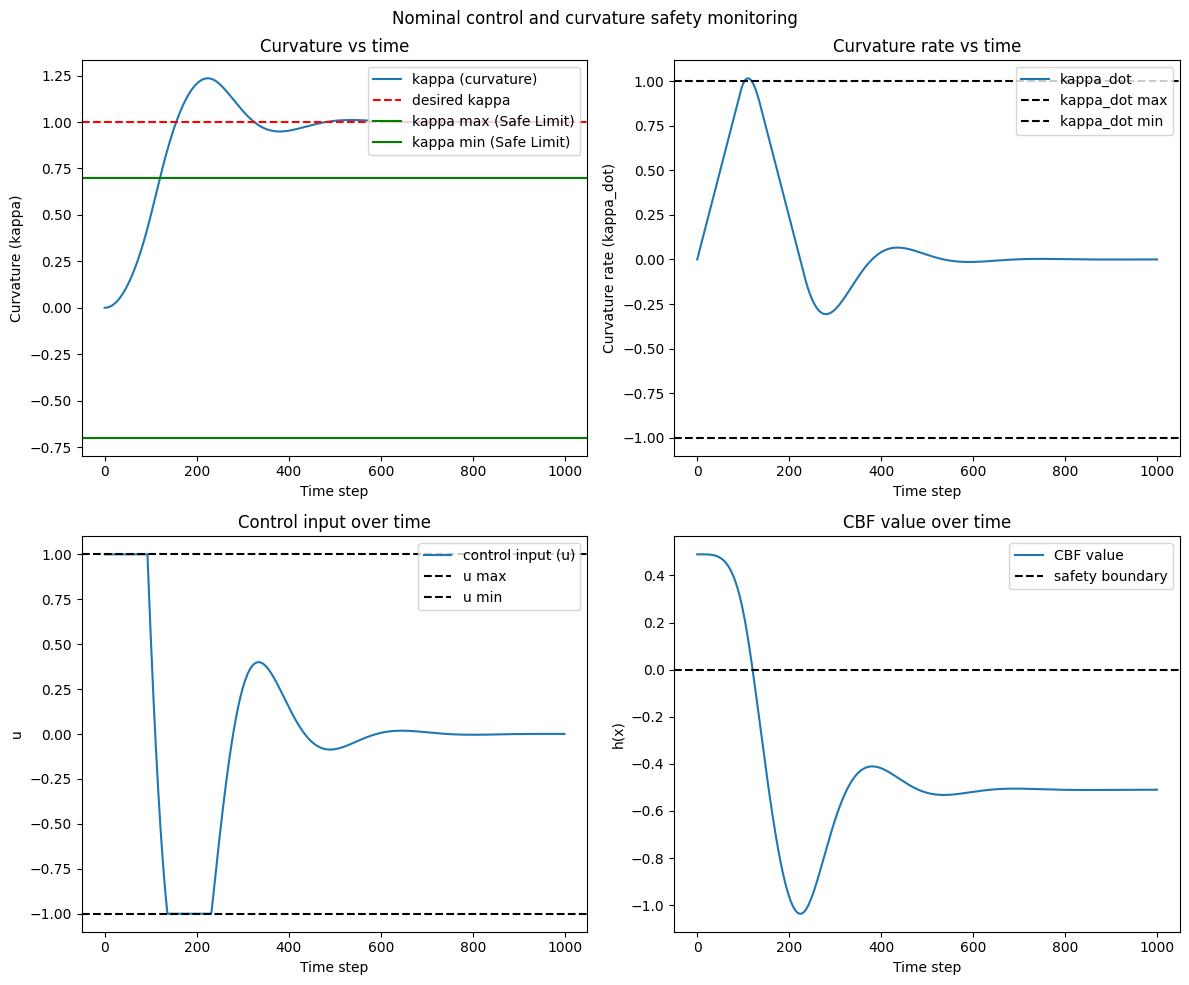

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Row 1, Col 1: Curvature over time
ax[0, 0].plot(states[:, 0], label='kappa (curvature)')
ax[0, 0].axhline(kappa_desired, color='r', linestyle='--', label='desired kappa')
ax[0, 0].axhline(cbf.kappa_max, color='g', linestyle='-', label='kappa max (Safe Limit)')
ax[0, 0].axhline(-cbf.kappa_max, color='g', linestyle='-', label='kappa min (Safe Limit)')

ax[0, 0].set_title("Curvature vs time")
ax[0, 0].set_xlabel("Time step")
ax[0, 0].set_ylabel("Curvature (kappa)")
ax[0, 0].legend(loc='upper right')

# Row 1, Col 2: Curvature rate over time (state[1])
ax[0, 1].plot(states[:, 1], label='kappa_dot')
ax[0, 1].axhline(dynamics.umax[0], color='k', linestyle='--', label='kappa_dot max')
ax[0, 1].axhline(dynamics.umin[0], color='k', linestyle='--', label='kappa_dot min')
ax[0, 1].set_title("Curvature rate vs time")
ax[0, 1].set_xlabel("Time step")
ax[0, 1].set_ylabel("Curvature rate (kappa_dot)")
ax[0, 1].legend(loc='upper right')

# Row 2, Col 1: Control input applied
ax[1, 0].plot(controls, label='control input (u)')
ax[1, 0].axhline(dynamics.umax[0], color='k', linestyle='--', label='u max')
ax[1, 0].axhline(dynamics.umin[0], color='k', linestyle='--', label='u min')
ax[1, 0].set_title("Control input over time")
ax[1, 0].set_xlabel("Time step")
ax[1, 0].set_ylabel("u")
ax[1, 0].legend(loc='upper right')

# Row 2, Col 2: CBF value over time
ax[1, 1].plot(vfs, label='CBF value')
ax[1, 1].axhline(0.0, color='k', linestyle='--', label='safety boundary')
ax[1, 1].set_title("CBF value over time")
ax[1, 1].set_xlabel("Time step")
ax[1, 1].set_ylabel("h(x)")
ax[1, 1].legend(loc='upper right')

fig.suptitle("Nominal control and curvature safety monitoring")
plt.tight_layout()
plt.show()


In [10]:

## Initializes the CBF 
dynamics = DoubleInt()
cbf = SimpleCBF(dynamics)
safety_filter = SafetyFilter(cbf)

In [11]:
states = []
vfs = []
controls = []
qp_feasibles = []
state = starting_state

for t in range(1000):
    states.append(state)
    control, qp_feasible = safety_filter(state, nominal_control(state))
    controls.append(control)
    qp_feasibles.append(qp_feasible)
    vf = cbf.vf(state)
    vfs.append(vf)
    state = dynamics.step(state, control)

states = np.array(states)
vfs = np.array(vfs)
controls = np.array(controls)


Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Open-loop dynamics output dimensions: (2,)
Control Jacobian shape: (2, 1)
Resulting dimensions in __call__: (2,)
Control dimensions inside step: (1,)
State dimensions in __call__: (2,)
Control dimensions in __call__: (1,)
Ope

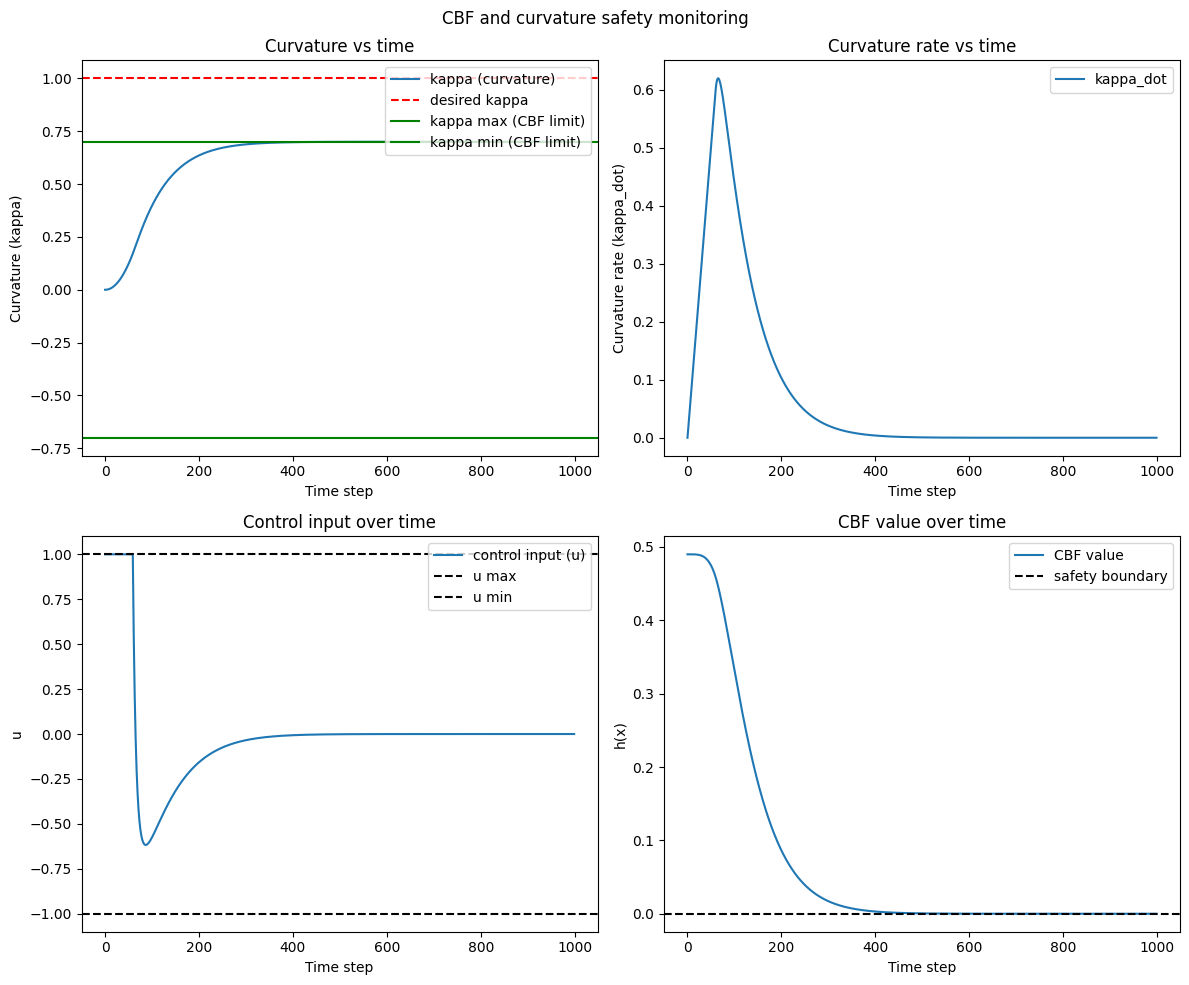

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Row 1, Col 1: Curvature over time (kappa)
ax[0, 0].plot(states[:, 0], label='kappa (curvature)')
ax[0, 0].axhline(kappa_desired, color='r', linestyle='--', label='desired kappa')

ax[0, 0].axhline(cbf.kappa_max, color='g', linestyle='-', label='kappa max (CBF limit)')
ax[0, 0].axhline(-cbf.kappa_max, color='g', linestyle='-', label='kappa min (CBF limit)')
ax[0, 0].set_title("Curvature vs time")
ax[0, 0].set_xlabel("Time step")
ax[0, 0].set_ylabel("Curvature (kappa)")
ax[0, 0].legend(loc='upper right')

# Row 1, Col 2: Curvature rate over time (kappa_dot)
ax[0, 1].plot(states[:, 1], label='kappa_dot')
ax[0, 1].set_title("Curvature rate vs time")
ax[0, 1].set_xlabel("Time step")
ax[0, 1].set_ylabel("Curvature rate (kappa_dot)")
ax[0, 1].legend(loc='upper right')

# Row 2, Col 1: Control input applied (u)
ax[1, 0].plot(controls, label='control input (u)')

ax[1, 0].axhline(dynamics.umax[0], color='k', linestyle='--', label='u max')
ax[1, 0].axhline(dynamics.umin[0], color='k', linestyle='--', label='u min')
ax[1, 0].set_title("Control input over time")
ax[1, 0].set_xlabel("Time step")
ax[1, 0].set_ylabel("u")
ax[1, 0].legend(loc='upper right')


# Row 2, Col 2: CBF value over time (h(x))
ax[1, 1].plot(vfs, label='CBF value')
ax[1, 1].axhline(0.0, color='k', linestyle='--', label='safety boundary')
ax[1, 1].set_title("CBF value over time")
ax[1, 1].set_xlabel("Time step")
ax[1, 1].set_ylabel("h(x)")
ax[1, 1].legend(loc='upper right')

fig.suptitle("CBF and curvature safety monitoring")
plt.tight_layout()
plt.savefig('cbf_plots.png')
